Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


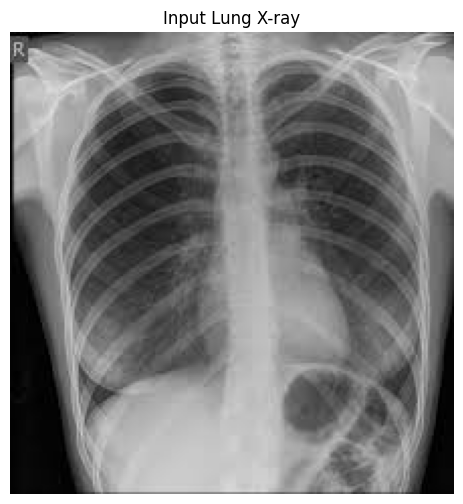

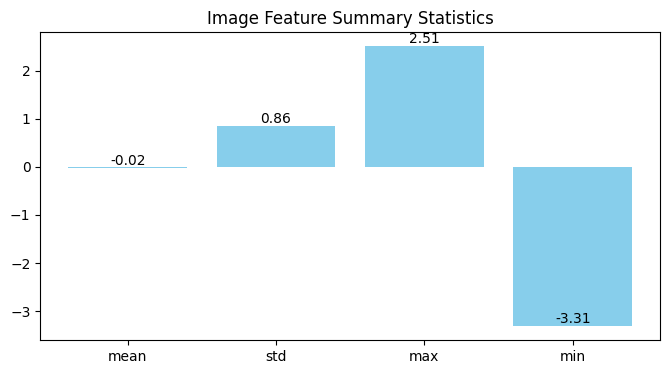

Generated Lung X-ray Report:

A pulmonary embolism is present. The patient is presented with a chest X ray, a CT scan, and a lung histogram. Note: It is possible that there may be some residual lung volume present in this area. A diagnosis of this condition is not expected. You should check the X screen for any abnormalities. This will help you determine if there are any other conditions that might


In [13]:
import torch
import torch.nn as nn
from transformers import ViTModel, AutoTokenizer, AutoModelForCausalLM
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ----------------------
# ViT Feature Extractor
# ----------------------
class ViTFeatureExtractor(nn.Module):
    def __init__(self, model_name="google/vit-base-patch16-224"):
        super(ViTFeatureExtractor, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.feature_dim = self.vit.config.hidden_size

    def forward(self, images):
        outputs = self.vit(pixel_values=images)
        # Use the [CLS] token representation as the image feature.
        return outputs.last_hidden_state[:, 0, :]

# ----------------------
# LLM Text Generator specialized for lung X-ray reports with disease detection
# ----------------------
class LLMTextGenerator(nn.Module):
    def __init__(self, model_name="openai-community/gpt2"):
        super(LLMTextGenerator, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # GPT-2 does not have a pad_token, so set it to eos_token.
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

    def generate_report(self, features):
        # Compute summary statistics from image features.
        feat = features[0]  # assume a single image
        mean_feat = feat.mean().item()
        std_feat = feat.std().item()
        max_feat = feat.max().item()
        min_feat = feat.min().item()
        stats = {"mean": mean_feat, "std": std_feat, "max": max_feat, "min": min_feat}

        # Construct a prompt instructing the model to determine if any lung disease is present.
        prompt = (
            "Generate a detailed, expert-level lung X-ray report focused on disease detection. "
            "Your report should analyze the lung fields and explicitly state if any abnormality is detected. "
            "If a disease is detected, clearly mention the disease (e.g. pneumonia, consolidation, effusion) along with its location and severity; "
            "if no disease is detected, state that the lung fields are normal. "
            f"Image feature summary: mean={mean_feat:.4f}, std={std_feat:.4f}, max={max_feat:.4f}, min={min_feat:.4f}.\n\n"
            "Example Report: The lung fields are mostly clear; however, there is a subtle opacity noted in the right lower lobe consistent with early consolidation, suggesting a possible pneumonia. "
            "No pleural effusion is observed.\n\n"
            "Now, based on the image features, generate a detailed lung X-ray report that includes disease detection. Report:"
        )

        # Tokenize the prompt and move inputs to the same device as the model.
        inputs = self.tokenizer(prompt, return_tensors="pt")
        inputs = {key: value.to(self.model.device) for key, value in inputs.items()}

        # Generate the report using sampling with adjusted parameters.
        outputs = self.model.generate(
            **inputs,
            max_length=256,
            temperature=0.7,
            top_k=50,
            top_p=0.9,
            no_repeat_ngram_size=2,
            do_sample=True,
            num_return_sequences=1
        )

        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Remove the prompt portion from the generated text if present.
        if generated_text.startswith(prompt):
            generated_text = generated_text[len(prompt):].strip()
        return generated_text, stats

# ----------------------
# Full Pipeline: Image → ViT → LLM → Lung X-ray Report + Visualization Data
# ----------------------
def generate_cxr_report(image_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load models and move to device.
    vit_extractor = ViTFeatureExtractor().to(device)
    llm_generator = LLMTextGenerator().to(device)

    # Preprocess the image.
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Extract image features using ViT.
    with torch.no_grad():
        features = vit_extractor(image_tensor)

    # Generate a detailed lung X-ray report.
    report, stats = llm_generator.generate_report(features)
    return image, report, stats

# ----------------------
# Visualization
# ----------------------
def visualize_results(image, stats, report):
    # Display the image.
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Input Lung X-ray")
    plt.show()

    # Bar chart for feature statistics.
    stat_names = list(stats.keys())
    stat_values = [stats[name] for name in stat_names]
    plt.figure(figsize=(8,4))
    plt.bar(stat_names, stat_values, color="skyblue")
    plt.title("Image Feature Summary Statistics")
    for i, v in enumerate(stat_values):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
    plt.show()

    # Print the generated report.
    print("Generated Lung X-ray Report:\n")
    print(report)

# ----------------------
# Main
# ----------------------
if __name__ == "__main__":
    image_path = "/content/pn.jpeg"  # Replace with your lung X-ray image path.
    img, report, stats = generate_cxr_report(image_path)
    visualize_results(img, stats, report)
